дз 5
* Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями
* Добавьте первые разности по стоимости доллара и евро к рублю
* сделайте ее перрасчет (ресемплинг) в представление по неделям.
* Постройте модель предсказания 1-й точки от текущей (h=1, p, q и d - необходимо выбрать с учетом задачи).
* Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
brent_data = pd.read_csv('my_BRENT2019.csv', index_col=[0]).loc[:,['Значение']]
brent_data.sort_index(inplace=True)
brent_data.index = pd.to_datetime(brent_data.index)
brent_data.head()

,Значение
Дата,
2010-09-01,76.37
2010-09-02,76.89
2010-09-03,76.57
2010-09-04,76.62
2010-09-05,76.63


Курсы валют

In [3]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.rename(columns={'curs':'curs_doll'},inplace=True)
rub_doll.head()

,curs_doll
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [4]:
rub_euro=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_euro.index = pd.to_datetime(rub_euro['data'].values).date
rub_euro.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_euro.rename(columns={'curs':'curs_euro'},inplace=True)
rub_euro.head()

,curs_euro
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


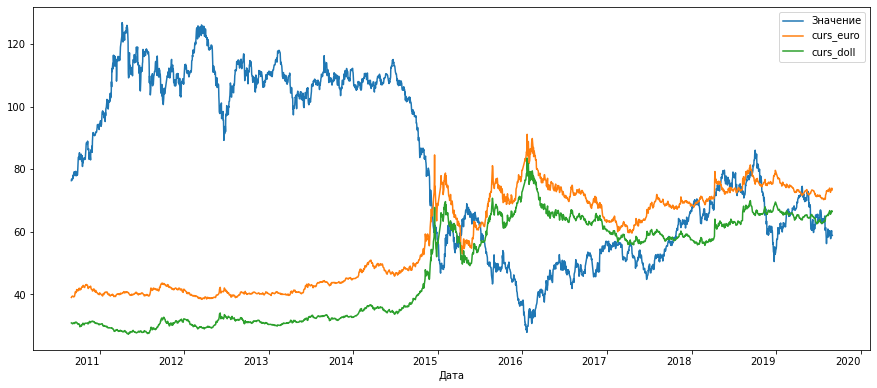

In [5]:
plt.figure(figsize=(15, 7))
brent_data['Значение'].plot()
rub_euro['curs_euro'].plot()
rub_doll['curs_doll'].plot()
plt.legend()
plt.show()

In [6]:
brent_data = pd.concat([brent_data, rub_doll, rub_euro], axis=1)

In [7]:
brent_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3137 entries, 2010-09-01 to 2019-09-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Значение   2667 non-null   float64
 1   curs_doll  2228 non-null   float64
 2   curs_euro  2228 non-null   float64
dtypes: float64(3)
memory usage: 98.0 KB


propagate last valid observation forward to next valid backfill

In [8]:
brent_data['curs_doll'].fillna(method='ffill', inplace=True)
brent_data['curs_euro'].fillna(method='ffill', inplace=True)
brent_data['Значение'].fillna(method='ffill', inplace=True)
brent_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3137 entries, 2010-09-01 to 2019-09-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Значение   3137 non-null   float64
 1   curs_doll  3137 non-null   float64
 2   curs_euro  3137 non-null   float64
dtypes: float64(3)
memory usage: 98.0 KB


Ресемплинг по неделям

In [9]:
brent_data_w= brent_data.resample('W').mean()
brent_data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Значение   470 non-null    float64
 1   curs_doll  470 non-null    float64
 2   curs_euro  470 non-null    float64
dtypes: float64(3)
memory usage: 14.7 KB


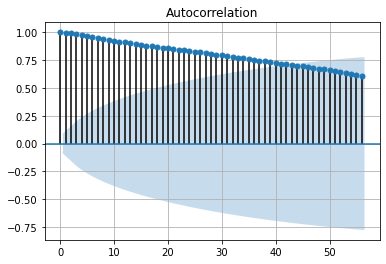

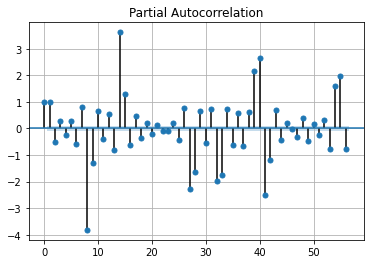

In [10]:
plot_acf(brent_data_w['Значение'], lags=56)
plt.grid(True)
plt.show()

plot_pacf(brent_data_w['Значение'], lags=56)
plt.grid(True)
plt.show()

Первые разности

In [11]:
brent_data_w['brent_diff'] = brent_data_w['Значение'].diff(1)
brent_data_w['doll_diff'] = brent_data_w['curs_doll'].diff(1)
brent_data_w['euro_diff'] = brent_data_w['curs_euro'].diff(1)
brent_data_w.dropna(inplace=True)

Проверим разности на стационарность

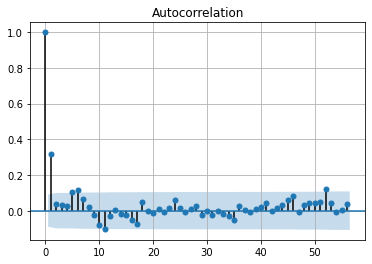

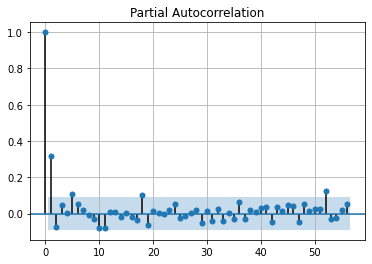

In [12]:
plot_acf(brent_data_w['brent_diff'], lags=56)
plt.grid(True)
plt.show()

plot_pacf(brent_data_w['brent_diff'], lags=56)
plt.grid(True)
plt.show()

In [13]:
import itertools

# Определим p, d и q в диапазоне 0-5
p = q = range(0, 5)
d = (0,1)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

In [14]:
warnings.filterwarnings("ignore")
res = []
for param in pdq:
    mod = SARIMAX(brent_data_w['Значение'].values[:-15],
                                    order=param,
                                    seasonal_order=(0,0,0,0) ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    res.append( param  + (results.aic,) )


Лучшие модели

In [15]:
pd.DataFrame(res,columns=['p','d','q','AIC']).sort_values(['AIC']).head(3)

,p,d,q,AIC
29,2,1,4,1963.317236
49,4,1,4,1964.505662
39,3,1,4,1964.893285


p=2
d=1
q=4

In [16]:
best_mod = SARIMAX(brent_data_w['Значение'].values[:-10],
                   order=(2,1,4),
                   seasonal_order=(0,0,0,0),
                   enforce_stationarity=False,
                   enforce_invertibility=False)
best_res = best_mod.fit()

Остатки

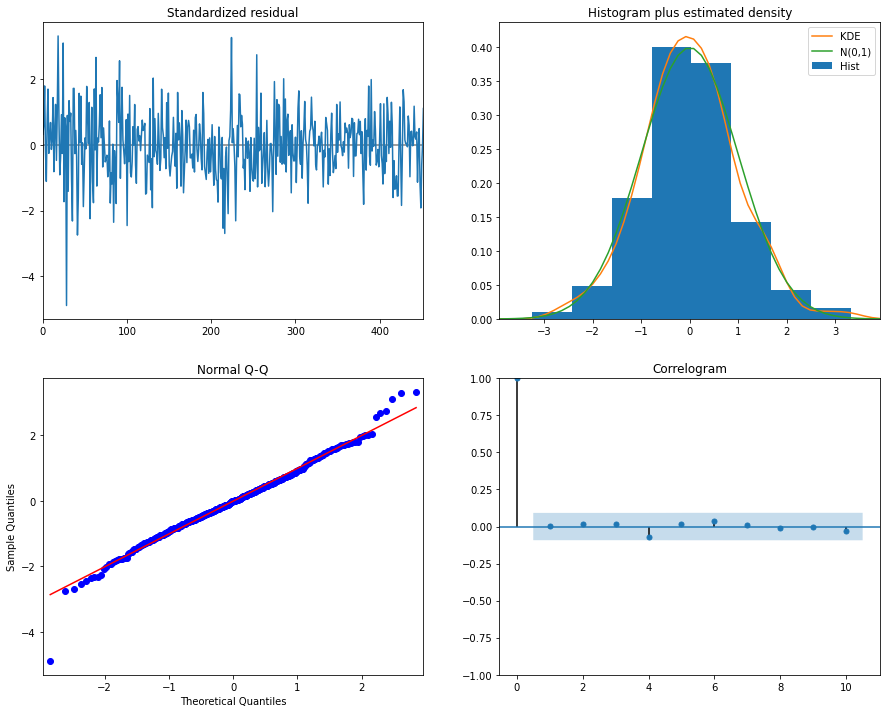

In [17]:
best_res.plot_diagnostics(figsize=(15, 12))
plt.show()

Остатки стационарны

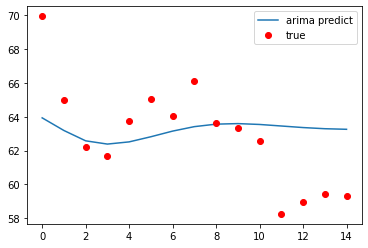

In [18]:
POINTS = 15
pred_arima = best_res.forecast(POINTS)  
plt.plot(pred_arima, label='arima predict' )
plt.plot(brent_data_w['Значение'].values[-POINTS:],'or',label='true')
plt.legend()
plt.plot()
plt.show()

### Прямое моделирование
Добавим сглаживание MA(4)

In [19]:
brent_data_w['MA']=brent_data_w['Значение'].rolling(4).mean()
brent_data_w.head()

,Значение,curs_doll,curs_euro,brent_diff,doll_diff,euro_diff,MA
2010-09-12,77.673333,30.777050,39.302883,1.057333,0.029610,0.069043,NaN
2010-09-19,78.590000,30.887129,39.984557,0.916667,0.110079,0.681674,NaN
2010-09-26,78.558571,31.003800,41.040657,-0.031429,0.116671,1.056100,NaN
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,79.101190
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,80.721071


глубина истории 2

In [20]:
brent_data_w['p1'] = 0
brent_data_w['p2'] = 0

brent_data_w['p1'].values[1:]=brent_data_w['Значение'].values[:-1]
brent_data_w['p2'].values[2:]=brent_data_w['Значение'].values[:-2]  


In [21]:
brent_data_w.dropna(inplace=True)  
brent_data_w.head()

,Значение,curs_doll,curs_euro,brent_diff,doll_diff,euro_diff,MA,p1,p2
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,79.101190,78,78
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,80.721071,81,78
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,81.921786,84,81
2010-10-24,82.810000,30.512871,42.491329,-0.582857,0.495214,0.503814,82.984643,83,84
2010-10-31,83.330000,30.562071,42.509329,0.520000,0.049200,0.018000,83.421429,82,83


Горизонт прогноза h=1

In [22]:
h=1
data = brent_data_w.iloc[:-h,:].copy()
data['target'] = 0
data['target']=brent_data_w.iloc[h:,0].values.copy()

data.head()

,Значение,curs_doll,curs_euro,brent_diff,doll_diff,euro_diff,MA,p1,p2,target
2010-10-03,81.582857,30.585086,41.382686,3.024286,-0.418714,0.342029,79.101190,78,78,84.152857
2010-10-10,84.152857,30.112129,41.636057,2.570000,-0.472957,0.253371,80.721071,81,78,83.392857
2010-10-17,83.392857,30.017657,41.987514,-0.760000,-0.094471,0.351457,81.921786,84,81,82.810000
2010-10-24,82.810000,30.512871,42.491329,-0.582857,0.495214,0.503814,82.984643,83,84,83.330000
2010-10-31,83.330000,30.562071,42.509329,0.520000,0.049200,0.018000,83.421429,82,83,87.003333


### Разделение данных на train и test

In [23]:
def split_data_b(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

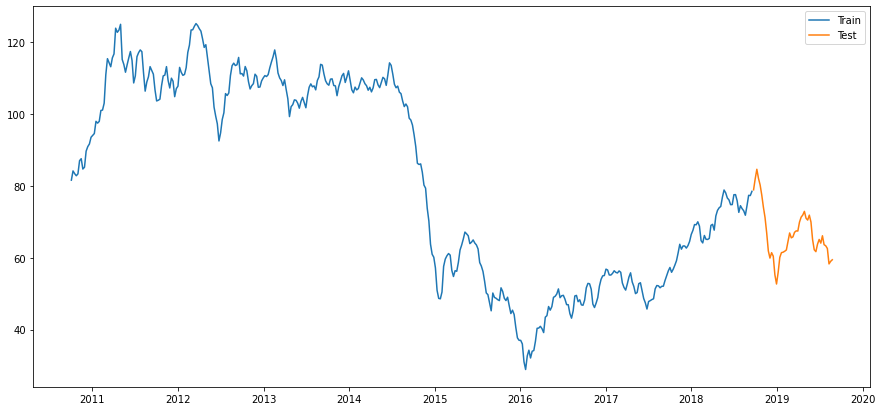

In [24]:
train, test = split_data_b(data, '2018-09-16')

plt.figure( figsize=(15, 7))
plt.plot(train.index, train.iloc[:,0], label='Train' )
plt.plot(test.index, test.iloc[:,0], label='Test')
plt.legend()
plt.show()

In [25]:
X_train = train.drop(['target'],axis=1)
y_train = train['target'].values[:]
X_test  = test.drop(['target'],axis=1)
y_test  = test['target'].values[:]


### Обучение модели

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
boost = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=1500)

In [28]:
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

feature importances

In [29]:
pd.Series(boost.feature_importances_, index=X_train.columns).sort_values(ascending=False)

curs_euro     0.316550
Значение      0.271912
curs_doll     0.271302
MA            0.136789
brent_diff    0.001371
doll_diff     0.000662
euro_diff     0.000612
p1            0.000461
p2            0.000341
dtype: float64

In [30]:
y_test_pred = boost.predict(X_test)

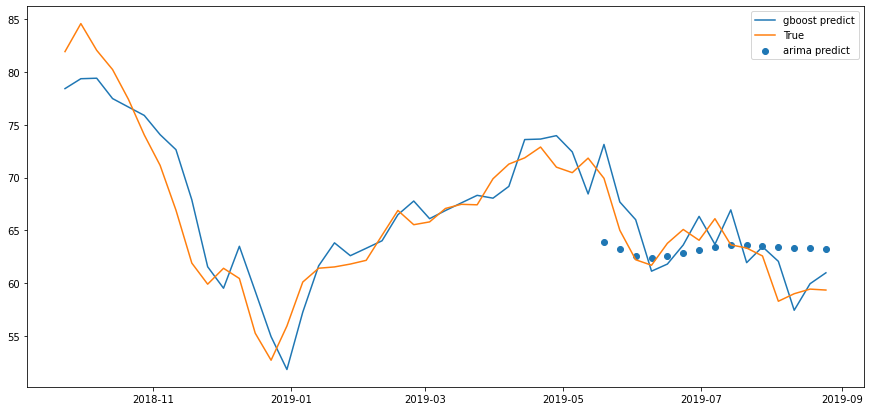

In [31]:
plt.figure( figsize=(15, 7))
plt.plot(test.index,y_test_pred, label='gboost predict' )
plt.plot(test.index,y_test, label='True')
plt.scatter(test.index[-15:], pred_arima, label='arima predict' )
plt.legend()
plt.show()

In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
er = mean_absolute_percentage_error(y_test,y_test_pred)

print('ошибка градиентного бустинга MAPE :  ', er,'%')

ошибка градиентного бустинга MAPE :   3.3153505123969875 %


На отрезке последних 15 точек

In [34]:
er_g_15 = mean_absolute_percentage_error(y_test[-15:],y_test_pred[-15:])
er_a_15 = mean_absolute_percentage_error(y_test[-15:],pred_arima)

print('ошибка градиентного бустинга MAPE :  ', er_g_15,'%')
print('ошибка ARIMA MAPE :  ', er_a_15,'%')

ошибка градиентного бустинга MAPE :   3.3254805363306064 %
ошибка ARIMA MAPE :   3.7052591278497324 %
